# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [2]:
%matplotlib inline
%run setup_environment.py
%run ml_tools.py
%run custom_tools.py
%run Selene_Job.ipy

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

In [3]:
#import sys
#sys.path.append('/Users/pierreguilmin/anaconda3/envs/impact-annotator_env/lib/python3.6/site-packages')
#sys.path

## Get the data

In [4]:
# get raw data
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False)

# shuffle data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]

In [5]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [6]:
# create the is_somatic class
impact['is_somatic'] = impact.confidence_class != "UNLIKELY"
get_table(impact.is_somatic)
label_feature_name = 'is_somatic'

We will work on two types of datasets, a reduced dataset and a complete dataset:

In [7]:
# choose features
feature_names = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
                 'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
                 'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
                 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
                 'gene_type', label_feature_name]
impact = impact[feature_names].dropna()
    
# transform categorical features
categorical_features_names = [ 'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
impact = pd.get_dummies(impact, columns = categorical_features_names, sparse = True)
    
# complete dataset
X = impact.drop(label_feature_name, axis = 1)
y = impact[label_feature_name]

# reduced dataset
impact = pd.concat([impact[~impact.is_somatic],
                    impact[impact.is_somatic].iloc[0:20000]], ignore_index = True)
X_reduced = impact.drop(label_feature_name, axis = 1)
y_reduced = impact[label_feature_name]

In [8]:
print(X.shape)
print(y.shape)
get_table(y)

(194211, 45)
(194211,)


,count_,freq_
True,187012,96.3%
False,7199,3.7%


In [9]:
print(X_reduced.shape)
print(y_reduced.shape)
get_table(y_reduced)

(27199, 45)
(27199,)


,count_,freq_
True,20000,73.5%
False,7199,26.5%


## Main functions

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

# returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

In [11]:
from sklearn.model_selection import GridSearchCV

# inner cross validation on hyperparameters
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

In [12]:
i = 0
for train_index, test_index in cv_strategy.split(X, y):
    print("Fold %d :\n" % i,
          "  → train_index (%5d elements) %s\n" % (len(train_index), str(train_index)),
          "  → test_index  (%5d elements) %s"   % (len(test_index), str(test_index)))
    i += 1

Fold 0 :
   → train_index (155368 elements) [ 67477 187841 115880 ... 116189 113760  70862]
   → test_index  (38843 elements) [103938  63291 102764 ... 169308 150580 184451]
Fold 1 :
   → train_index (155368 elements) [ 52375 116172 151753 ...  61523 187353  12006]
   → test_index  (38843 elements) [  8533  24687  44893 ...  25536 155855  88629]
Fold 2 :
   → train_index (155368 elements) [169673  29150  45540 ... 147126 104210  50603]
   → test_index  (38843 elements) [ 37007  13893 105448 ...  45423 148192 150267]
Fold 3 :
   → train_index (155368 elements) [177062  88964  28868 ... 116607  90306  54130]
   → test_index  (38843 elements) [141468 137405 159885 ... 158469  43755 110291]
Fold 4 :
   → train_index (155368 elements) [131998 149198 151911 ... 153142 139426 176304]
   → test_index  (38843 elements) [183259 178701 193094 ...   2010  51741 189501]


In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)

In [15]:
print("mean : %s " % X_train_scaled.mean(axis=0))
print("standard deviation : %s " % X_train_scaled.std(axis=0))

mean : [-6.01475847e-17  2.85627855e-16 -2.25370512e-17 -1.58783770e-16
  3.10250315e-17  7.88430931e-18  2.09053102e-16  3.24701834e-17
 -1.70491329e-17  1.09758366e-18  5.35986689e-18 -2.00857810e-17
  1.83479402e-17 -1.99028504e-17  1.00611836e-17 -1.54027574e-17
 -1.69027884e-17 -9.80508072e-18 -2.30492569e-18 -1.37197958e-18
  1.71954774e-17 -2.78603320e-17  3.29640960e-17  2.61590773e-17
  5.89402427e-17  4.71960975e-18  1.77808553e-17  4.16533000e-17
  2.14028814e-18  1.07343682e-16 -2.60493189e-17  5.50621137e-17
 -6.84892206e-17 -9.31116807e-18  4.05374233e-17 -4.05374233e-17
  2.10370202e-18 -5.40011162e-17  8.10748466e-17 -6.73184646e-17
 -4.56594804e-17  5.67450754e-17  2.91225532e-17 -8.27578082e-17
 -8.80445028e-17] 
standard deviation : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 


In [27]:
X_train_scaled

array([[ 0.02934632, -1.04049166, -0.36653767, ..., -0.158219  ,
         1.01349398, -0.55394056],
       [-0.56860895, -0.85280065, -0.40980176, ..., -0.158219  ,
        -0.98668568,  1.80524784],
       [-0.06556722,  0.13666123,  0.01418631, ..., -0.158219  ,
         1.01349398, -0.55394056],
       ...,
       [-0.23957536, -1.07198896, -0.40980176, ..., -0.158219  ,
         1.01349398, -0.55394056],
       [ 1.18096386, -0.13647209,  0.43240583, ..., -0.158219  ,
        -0.98668568, -0.55394056],
       [-0.07980425,  0.87608389,  0.25069666, ..., -0.158219  ,
         1.01349398, -0.55394056]])

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters_grid = [
    {'n_neighbors': [2, 10]}
]
pipe = Pipeline([('scale', StandardScaler()),
                 ('classify', GridSearchCV(KNeighborsClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True))])

metrics_reduced = run_model(pipe, X_reduced, y_reduced, cv_strategy)
print_mean_metrics(metrics_reduced)

Run model
  - fold 1/5... done! (193.04s)
  - fold 2/5... done! (187.69s)
  - fold 3/5... done! (180.32s)
  - fold 4/5... done! (192.61s)
  - fold 5/5... done! (168.50s)
▴ Mean accuracy: 0.86 ± 0.01
▴ Mean ROC AUC : 0.84 ± 0.01


In [26]:
metrics_reduced

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,test_fpr,test_tpr,gs_best_parameters,gs_cv_results
fold_number,,,,,,,,,,
0,159.192,33.8521,0.874259,0.861213,0.920401,0.844011,"[0.0, 0.09097222222222222, 0.19027777777777777, 0.28958333333333336, 0.36180555555555555, 0.41875, 0.46805555555555556, 0.5159722222222223, 0.5576388888888889, 0.6173611111111111, 0.7048611111111112, 1.0]","[0.0, 0.403, 0.6875, 0.84075, 0.9225, 0.962, 0.982, 0.9905, 0.99475, 0.9975, 0.99875, 1.0]",NaN,NaN
1,153.759,33.9311,0.874305,0.849081,0.920163,0.841895,"[0.0, 0.07430555555555556, 0.19652777777777777, 0.2965277777777778, 0.37083333333333335, 0.4354166666666667, 0.46944444444444444, 0.5083333333333333, 0.5506944444444445, 0.5965277777777778, 0.7131944444444445, 1.0]","[0.0, 0.39475, 0.677, 0.83375, 0.9185, 0.9515, 0.9745, 0.9845, 0.9885, 0.9935, 0.99775, 1.0]",NaN,NaN
2,146.908,33.4133,0.875776,0.854963,0.920344,0.84238,"[0.0, 0.07430555555555556, 0.20069444444444445, 0.3020833333333333, 0.3770833333333333, 0.42569444444444443, 0.4722222222222222, 0.5152777777777777, 0.5555555555555556, 0.6027777777777777, 0.7083333333333334, 1.0]","[0.0, 0.4005, 0.68325, 0.8415, 0.91725, 0.956, 0.97375, 0.983, 0.99075, 0.99525, 0.998, 1.0]",NaN,NaN
3,159.369,33.2387,0.874443,0.855515,0.920733,0.842012,"[0.0, 0.0875, 0.19027777777777777, 0.2763888888888889, 0.36944444444444446, 0.4284722222222222, 0.47430555555555554, 0.5145833333333333, 0.5576388888888889, 0.6034722222222222, 0.6930555555555555, 1.0]","[0.0, 0.398, 0.67175, 0.83825, 0.91975, 0.95775, 0.97725, 0.986, 0.9915, 0.9945, 0.99575, 1.0]",NaN,NaN
4,139.179,29.3209,0.87265,0.859743,0.919041,0.849888,"[0.0, 0.08263888888888889, 0.18333333333333332, 0.2722222222222222, 0.3458333333333333, 0.4083333333333333, 0.44722222222222224, 0.49027777777777776, 0.5305555555555556, 0.5902777777777778, 0.6875, 1.0]","[0.0, 0.40125, 0.68125, 0.8385, 0.9125, 0.95625, 0.977, 0.989, 0.99375, 0.9965, 0.998, 1.0]",NaN,NaN


In [28]:
%run ml_tools.py

In [29]:
model_GS_KNeighborsClassifier = GridSearchCV(KNeighborsClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)
metrics_integrated = run_model(model_GS_KNeighborsClassifier, X_reduced, y_reduced, cv_strategy, grid_search = True)
print_mean_metrics(metrics_integrated)

Run model
  - fold 1/5... done! (186.42s)
  - fold 2/5... done! (184.24s)
  - fold 3/5... done! (174.57s)
  - fold 4/5... done! (190.09s)
  - fold 5/5... done! (175.37s)
▴ Mean accuracy: 0.86 ± 0.01
▴ Mean ROC AUC : 0.84 ± 0.01


In [30]:
metrics_integrated

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,test_fpr,test_tpr,gs_best_parameters,gs_cv_results
fold_number,,,,,,,,,,
0,154.217,32.1995,0.874259,0.861213,0.920401,0.844011,"[0.0, 0.09097222222222222, 0.19027777777777777, 0.28958333333333336, 0.36180555555555555, 0.41875, 0.46805555555555556, 0.5159722222222223, 0.5576388888888889, 0.6173611111111111, 0.7048611111111112, 1.0]","[0.0, 0.403, 0.6875, 0.84075, 0.9225, 0.962, 0.982, 0.9905, 0.99475, 0.9975, 0.99875, 1.0]",{'n_neighbors': 10},"{'mean_fit_time': [0.1371603012084961, 0.1376983324686686], 'std_fit_time': [0.00870321494115891, 0.0035651549451107775], 'mean_score_time': [3.6636414527893066, 4.690464973449707], 'std_score_time': [0.15983196355556328, 0.07335674068130439], 'param_n_neighbors': [2, 10], 'params': [{'n_neighbors': 2}, {'n_neighbors': 10}], 'split0_test_score': [0.8031871202256945, 0.8392519802517362], 'split1_test_score': [0.8028701443142361, 0.8370567491319445], 'split2_test_score': [0.8009771050347223, 0.8524702962239583], 'mean_test_score': [0.8023447898582176, 0.842926341869213], 'std_test_score': [0.0009757184581718242, 0.00680784148177291], 'rank_test_score': [2, 1], 'split0_train_score': [0.9775321182439765, 0.9183198970316909], 'split1_train_score': [0.976772014733015, 0.9194728724630996], 'split2_train_score': [0.9774873833297156, 0.916502333405687], 'mean_train_score': [0.9772638387689024, 0.9180983676334925], 'std_train_score': [0.00034825131236496343, 0.0012227924404419816]}"
1,152.184,32.0561,0.874305,0.849081,0.920163,0.841895,"[0.0, 0.07430555555555556, 0.19652777777777777, 0.2965277777777778, 0.37083333333333335, 0.4354166666666667, 0.46944444444444444, 0.5083333333333333, 0.5506944444444445, 0.5965277777777778, 0.7131944444444445, 1.0]","[0.0, 0.39475, 0.677, 0.83375, 0.9185, 0.9515, 0.9745, 0.9845, 0.9885, 0.9935, 0.99775, 1.0]",{'n_neighbors': 10},"{'mean_fit_time': [0.16150601704915366, 0.14862656593322754], 'std_fit_time': [0.01708604209674406, 0.011860161149199314], 'mean_score_time': [3.666979710261027, 4.53666615486145], 'std_score_time': [0.1502133638950093, 0.22617510189329937], 'param_n_neighbors': [2, 10], 'params': [{'n_neighbors': 2}, {'n_neighbors': 10}], 'split0_test_score': [0.790496826171875, 0.8387335883246527], 'split1_test_score': [0.8031027560763888, 0.8398682996961806], 'split2_test_score': [0.80102294921875, 0.8360146755642361], 'mean_test_score': [0.7982075104890045, 0.8382055211950231], 'std_test_score': [0.0055179941174362465, 0.0016169407137394934], 'rank_test_score': [2, 1], 'split0_train_score': [0.9778655273225526, 0.9179240150857391], 'split1_train_score': [0.9771307080258302, 0.9189842223789885], 'split2_train_score': [0.9778719374050359, 0.9199994064738442], 'mean_train_score': [0.9776227242511396, 0.9189692146461906], 'std_train_score': [0.0003479178511900868, 0.0008473414414067837]}"
2,141.205,33.366,0.875776,0.854963,0.920344,0.84238,"[0.0, 0.07430555555555556, 0.20069444444444445, 0.3020833333333333, 0.3770833333333333, 0.42569444444444443, 0.4722222222222222, 0.5152777777777777, 0.5555555555555556, 0.6027777777777777, 0.7083333333333334, 1.0]","[0.0, 0.4005, 0.68325, 0.8415, 0.91725, 0.956, 0.97375, 0.983, 0.99075, 0.99525, 0.998, 1.0]",{'n_neighbors': 10},"{'mean_fit_time': [0.1398018995920817, 0.14048409461975098], 'std_fit_time': [0.015235102801870739, 0.005131937893470601], 'mean_score_time': [3.2755544185638428, 4.263309637705485], 'std_score_time': [0.3785420802212066, 0.2918953159254936], 'param_n_neighbors': [2, 10], 'params': [{'n_neighbors': 2}, {'n_neighbors': 10}], 'split0_test_score': [0.8029347059461805, 0.8451047092013888], 'split1_test_score': [0.8039000108506944, 0.843351779513889], 'split2_test_score': [0.7901783582899305, 0.826427544487847], 'mean_test_score': [0.7990043583622685, 0.838294677734375], 'std_test_score': [0.006253354371713993, 0.008421790357576989], 'rank_test_score': [2, 1], 'split0_train_score': [0.9788985172020839, 0.9190605837584112], '

In [31]:
%run ml_tools.py

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters_grid = [
    {'classify__n_neighbors': [2, 10]}
]
pipe = Pipeline([('scale', StandardScaler()),
                 ('classify', KNeighborsClassifier())])

model_GS_KNeighborsClassifier = GridSearchCV(pipe, parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

metrics_piped = run_model(model_GS_KNeighborsClassifier, X_reduced, y_reduced, cv_strategy, grid_search = True)
print_mean_metrics(metrics_piped)

Run model
  - fold 1/5... done! (182.37s)
  - fold 2/5...

In [ ]:
metrics_piped

In [22]:
model_GS_KNeighborsClassifier = GridSearchCV(KNeighborsClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)
metrics = run_model(model_GS_KNeighborsClassifier, X_reduced, y_reduced, cv_strategy, grid_search = True)
print_mean_metrics(metrics)

Run model
  - fold 1/5... done! (18.44s)
  - fold 2/5... done! (18.84s)
  - fold 3/5... done! (18.72s)
  - fold 4/5... done! (17.36s)
  - fold 5/5... done! (18.21s)
▴ Mean accuracy: 0.79 ± 0.01
▴ Mean ROC AUC : 0.77 ± 0.01


In [23]:
metrics

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,test_fpr,test_tpr,gs_best_parameters,gs_cv_results
fold_number,,,,,,,,,,
0,15.1937,3.24729,0.821867,0.795037,0.861629,0.7814,"[0.0, 0.06319444444444444, 0.1638888888888889, 0.28958333333333336, 0.41875, 0.5090277777777777, 0.6090277777777777, 0.7083333333333334, 0.7847222222222222, 0.8680555555555556, 0.9361111111111111, 1.0]","[0.0, 0.26675, 0.52175, 0.7145, 0.839, 0.9045, 0.9455, 0.971, 0.9855, 0.99475, 0.99825, 1.0]",{'n_neighbors': 10},"{'mean_fit_time': [0.1691429615020752, 0.1645959218343099], 'std_fit_time': [0.030010407528980675, 0.03681067614475312], 'mean_score_time': [0.28513439496358234, 0.4619599978129069], 'std_score_time': [0.01795218447458526, 0.04646530369290756], 'param_n_neighbors': [2, 10], 'params': [{'n_neighbors': 2}, {'n_neighbors': 10}], 'split0_test_score': [0.7135485839843749, 0.7665048556857639], 'split1_test_score': [0.7237076822916666, 0.7772738986545138], 'split2_test_score': [0.71714111328125, 0.7615450032552084], 'mean_test_score': [0.7181324598524305, 0.7684412525318287], 'std_test_score': [0.004206256896770783, 0.006565656208872563], 'rank_test_score': [2, 1], 'split0_train_score': [0.957701086661602, 0.8571046861433688], 'split1_train_score': [0.9576335009903407, 0.85780084145051], 'split2_train_score': [0.958411622259605, 0.8599431571521599], 'mean_train_score': [0.9579154033038493, 0.8582828949153463], 'std_train_score': [0.0003519629665920721, 0.0012078937795897155]}"
1,15.6133,3.22187,0.82444,0.793566,0.86295,0.771826,"[0.0, 0.06111111111111111, 0.18611111111111112, 0.30972222222222223, 0.42083333333333334, 0.5229166666666667, 0.6152777777777778, 0.7055555555555556, 0.7861111111111111, 0.8645833333333334, 0.9347222222222222, 1.0]","[0.0, 0.26825, 0.51575, 0.7125, 0.83375, 0.9075, 0.95025, 0.9715, 0.9855, 0.9925, 0.99725, 1.0]",{'n_neighbors': 10},"{'mean_fit_time': [0.17264612515767416, 0.1703801949818929], 'std_fit_time': [0.03564685362563938, 0.03343184407460625], 'mean_score_time': [0.3215896288553874, 0.4980352719624837], 'std_score_time': [0.020396667485751658, 0.030064353860278524], 'param_n_neighbors': [2, 10], 'params': [{'n_neighbors': 2}, {'n_neighbors': 10}], 'split0_test_score': [0.7059611002604167, 0.7541423882378472], 'split1_test_score': [0.7197111002604166, 0.7722915310329861], 'split2_test_score': [0.7102286783854168, 0.7602988009982639], 'mean_test_score': [0.7119669596354168, 0.762244240089699], 'std_test_score': [0.0057464099678596675, 0.0075359757604638805], 'rank_test_score': [2, 1], 'split0_train_score': [0.9585606905931192, 0.8611884598165835], 'split1_train_score': [0.9577848586390275, 0.859188319066095], 'split2_train_score': [0.9591717596863469, 0.8611193055404818], 'mean_train_score': [0.958505769639498, 0.8604986948077201], 'std_train_score': [0.0005675302412641017, 0.0009270055795068973]}"
2,15.5767,3.14156,0.82251,0.792647,0.862883,0.773975,"[0.0, 0.07013888888888889, 0.18680555555555556, 0.30625, 0.42986111111111114, 0.5166666666666667, 0.5979166666666667, 0.6840277777777778, 0.7618055555555555, 0.8430555555555556, 0.9319444444444445, 1.0]","[0.0, 0.2845, 0.52875, 0.71925, 0.83025, 0.904, 0.94825, 0.97275, 0.9855, 0.99325, 0.998, 1.0]",{'n_neighbors': 10},"{'mean_fit_time': [0.1694499651590983, 0.1671923796335856], 'std_fit_time': [0.03329068741588555, 0.039902489254500295], 'mean_score_time': [0.30209795633951825, 0.4712093671162923], 'std_score_time': [0.018817390525806315, 0.02351083963782115], 'param_n_neighbors': [2, 10], 'params': [{'n_neighbors': 2}, {'n_neighbors': 10}], 'split0_test_score': [0.7128453233506945, 0.7724085828993055], 'split1_test_score': [0.7199338107638888, 0.7761611599392361], 'split2_test_score': [0.7171493869357639, 0.7621080186631944], 'mean_test_score': [0.7166428403501158, 0.7702259205005787], 'std_test_score': [0.002915945305194357, 0.005941139413233128], 'rank_test_score': [2, 1], 'split0_train_score': [0.9579344696250272, 0.861026791770675], 'spli

## Dummy

### Uniform

In [15]:
from sklearn.dummy import DummyClassifier

model_uniform = DummyClassifier(strategy = 'uniform', random_state = 1)
# generates predictions uniformly at random
#   → expected accuracy: 0.5 | expected AUC: 0.5

In [54]:
metrics = run_model(model_uniform, X, y, cv_strategy)
print_mean_metrics(metrics)
print()
metrics_reduced = run_model(model_uniform, X_reduced, y_reduced, cv_strategy)
print_mean_metrics(metrics_reduced)

Run model
  → fold 1/5... done! (0.21s)
  → fold 2/5... done! (0.21s)
  → fold 3/5... done! (0.21s)
  → fold 4/5... done! (0.19s)
  → fold 5/5... done! (0.20s)
▴ Mean accuracy: 0.50 ± 0.00
▴ Mean ROC AUC : 0.50 ± 0.00

Run model
  → fold 1/5... done! (0.03s)
  → fold 2/5... done! (0.03s)
  → fold 3/5... done! (0.03s)
  → fold 4/5... done! (0.03s)
  → fold 5/5... done! (0.03s)
▴ Mean accuracy: 0.50 ± 0.01
▴ Mean ROC AUC : 0.50 ± 0.00


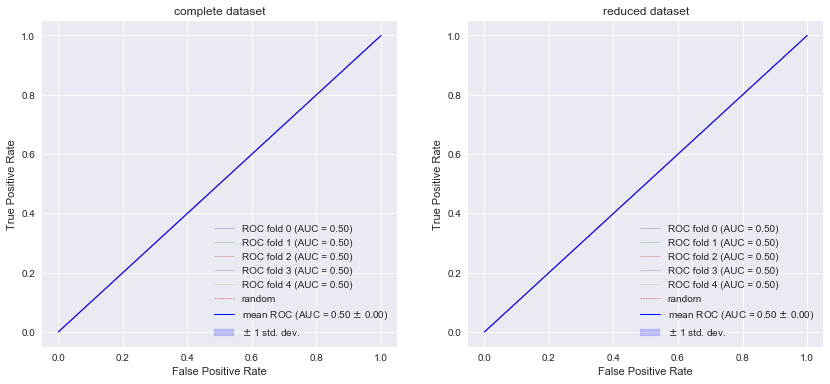

In [41]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14, 6))
plot_roc(metrics, ax0, "complete dataset")
plot_roc(metrics_reduced, ax1, "reduced dataset")

### Most Frequent

In [55]:
from sklearn.dummy import DummyClassifier

model_most_frequent = DummyClassifier(strategy = 'most_frequent', random_state = 1)
# always predicts the most frequent label in the training set
#   → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

In [56]:
metrics = run_model(model_most_frequent, X, y, cv_strategy)
print_mean_metrics(metrics)
print()
metrics_reduced = run_model(model_most_frequent, X_reduced, y_reduced, cv_strategy)
print_mean_metrics(metrics_reduced)

Run model
  → fold 1/5... done! (0.20s)
  → fold 2/5... done! (0.19s)
  → fold 3/5... done! (0.20s)
  → fold 4/5... done! (0.26s)
  → fold 5/5... done! (0.20s)
▴ Mean accuracy: 0.96 ± 0.00
▴ Mean ROC AUC : 0.50 ± 0.00

Run model
  → fold 1/5... done! (0.05s)
  → fold 2/5... done! (0.04s)
  → fold 3/5... done! (0.03s)
  → fold 4/5... done! (0.03s)
  → fold 5/5... done! (0.04s)
▴ Mean accuracy: 0.74 ± 0.00
▴ Mean ROC AUC : 0.50 ± 0.00


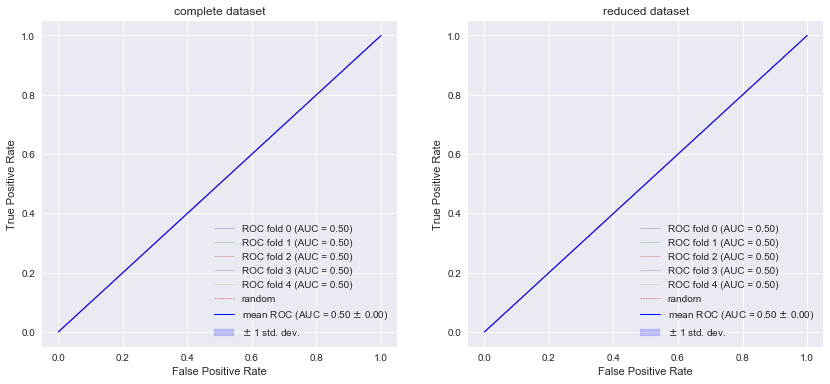

In [45]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14, 6))
plot_roc(metrics, ax0, "complete dataset")
plot_roc(metrics_reduced, ax1, "reduced dataset")

## Gaussian Naive Bayes

In [57]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()

In [66]:
%run ml_tools.py

In [58]:
metrics = run_model(model_GaussianNB, X, y, cv_strategy)
print_mean_metrics(metrics)
print()
metrics_reduced = run_model(model_GaussianNB, X_reduced, y_reduced, cv_strategy)
print_mean_metrics(metrics_reduced)

Run model
  → fold 1/5... done! (1.10s)
  → fold 2/5... done! (1.14s)
  → fold 3/5... done! (0.99s)
  → fold 4/5... done! (0.90s)
  → fold 5/5... done! (0.93s)
▴ Mean accuracy: 0.94 ± 0.00
▴ Mean ROC AUC : 0.80 ± 0.02

Run model
  → fold 1/5... done! (0.11s)
  → fold 2/5... done! (0.11s)
  → fold 3/5... done! (0.11s)
  → fold 4/5... done! (0.11s)
  → fold 5/5... done! (0.10s)
▴ Mean accuracy: 0.80 ± 0.01
▴ Mean ROC AUC : 0.80 ± 0.02


In [67]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [0.67s | 0.43s]
  → accuracy: [0.94 | 0.94]
  → ROC AUC : [0.79 | 0.80]
Fold 2: [0.63s | 0.51s]
  → accuracy: [0.94 | 0.94]
  → ROC AUC : [0.80 | 0.80]
Fold 3: [0.61s | 0.38s]
  → accuracy: [0.94 | 0.94]
  → ROC AUC : [0.79 | 0.80]
Fold 4: [0.52s | 0.38s]
  → accuracy: [0.94 | 0.94]
  → ROC AUC : [0.80 | 0.80]
Fold 5: [0.55s | 0.39s]
  → accuracy: [0.94 | 0.94]
  → ROC AUC : [0.81 | 0.80]


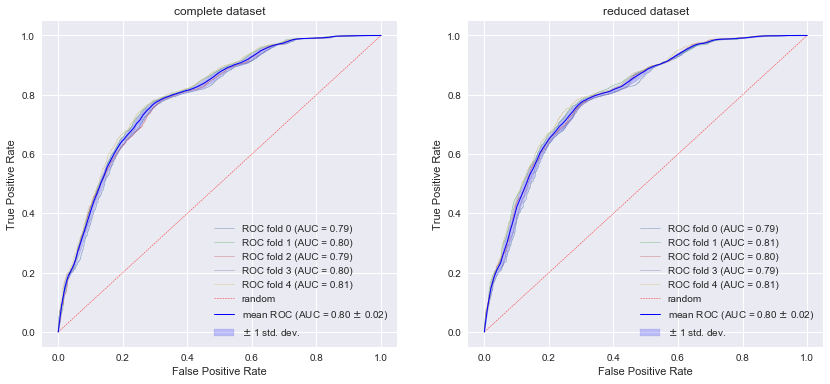

In [68]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14, 6))
plot_roc(metrics, ax0, "complete dataset")
plot_roc(metrics_reduced, ax1, "reduced dataset")

## Logistic Regression

In [117]:
job = Selene_Job('LogisticRegressionCV', 'guilminp', job_duration = 40, load_from_id = True)
job.load_data(X, y)

<span style='color:green'>Job < LogisticRegressionCV >: </span>✅ job found and reloaded<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_LogisticRegressionCV


<span style='color:green'>Job < LogisticRegressionCV >: </span>✅ data loaded<br>

In [112]:
job_reduced = Selene_Job('LogisticRegressionCV_reduced', 'guilminp', load_from_id = True)
job_reduced.load_data(X_reduced, y_reduced)

<span style='color:green'>Job < LogisticRegressionCV_reduced >: </span>✅ successfully found job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_LogisticRegressionCV_reduced


<span style='color:green'>Job < LogisticRegressionCV_reduced >: </span>✅ data loaded<br>

In [61]:
%%writefile {job.local_job_directory_path}/script.py

# load the ml_tools functions
print("Setup environment...", end = "")
import sys
sys.path.append("../../")

from ml_tools import *
print(" done!")


print("Run model...")
# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# choose a cross-validation strategy
from sklearn.model_selection import StratifiedShuffleSplit
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

# choose a model
from sklearn.linear_model import LogisticRegressionCV
model_LogisticRegressionCV = LogisticRegressionCV(random_state = 1)

# run the model
metrics = run_model(model_LogisticRegressionCV, X, y, cv_strategy, print_fold_metrics = True)
print(" done!")


print("Save metrics...", end = "")
metrics.to_pickle("metrics.pkl")
print(" done!")

Overwriting ssh_remote_jobs/job_LogisticRegressionCV/script.py


In [62]:
!cp {job.local_job_directory_path}/script.py {job_reduced.local_job_directory_path}

In [118]:
job.run()

➞ scp ssh_remote_jobs/job_LogisticRegressionCV to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
X.pkl                                         100%   37MB   9.8MB/s   00:03    
y.pkl                                         100% 3225KB  11.5MB/s   00:00    
script.py                                     100%  807    81.3KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_LogisticRegressionCV
Job <28116428> is submitted to default queue <sol>.


<span style='color:green'>Job < LogisticRegressionCV >: </span>✅ submitted<br>

In [64]:
job_reduced.run()

➞ scp ssh_remote_jobs/job_LogisticRegressionCV_reduced to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
X.pkl                                         100% 5053KB   7.8MB/s   00:00    
y.pkl                                         100%   27KB   2.0MB/s   00:00    
script.py                                     100%  807    86.9KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_LogisticRegressionCV_reduced
Job <28113424> is submitted to default queue <sol>.


<span style='color:green'>Job < LogisticRegressionCV_reduced >: </span>✅ submitted<br>

In [123]:
job.get_results()
job_reduced.get_results()

<span style='color:red'>Job < LogisticRegressionCV >: </span>⚠️ does not exist, is not done yet or an error occured before the creation of `metrics.pkl`<br>

<span style='color:green'>Job < LogisticRegressionCV_reduced >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_LogisticRegressionCV_reduced to ssh_remote_jobs/job_LogisticRegressionCV_reduced
metrics.pkl                                   100%  106KB   3.8MB/s   00:00    
job_output.txt                                100%   35KB   2.9MB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
## Mean accuracy: 0.97 ± 0.00
## Mean ROC AUC : 0.83 ± 0.01


AttributeError: 'Selene_Job' object has no attribute 'metrics'

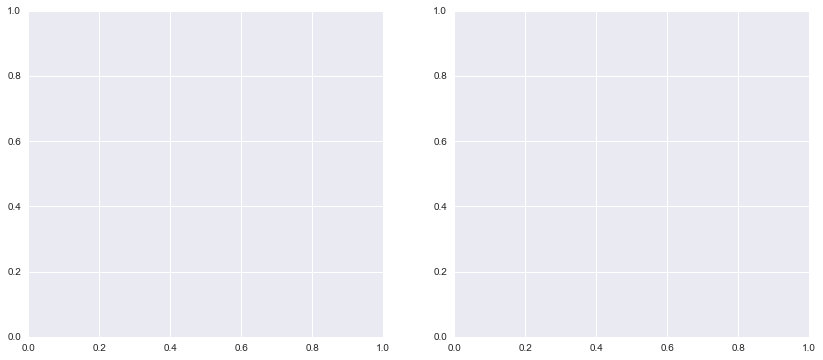

In [120]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14, 6))
plot_roc(cv_strategy.get_n_splits(), job.metrics, ax0, "complete dataset")
plot_roc(cv_strategy.get_n_splits(), job_reduced.metrics, ax1, "reduced dataset")

## K Nearest Neighbors

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters_grid = [
    {'n_neighbors': [2, 10]}
]

model_GS_KNeighborsClassifier = GridSearchCV(KNeighborsClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

# run the model
metrics = run_model(model_GS_KNeighborsClassifier, X_reduced, y_reduced, cv_strategy, grid_search = True)

Run model
  → fold 1/5... done! (25.27s)
  → fold 2/5... done! (29.50s)
  → fold 3/5... done! (24.43s)
  → fold 4/5... done! (22.56s)
  → fold 5/5... done! (23.85s)


In [73]:
print_mean_metrics(metrics)

▴ Mean accuracy: 0.79 ± 0.01
▴ Mean ROC AUC : 0.77 ± 0.01


In [84]:
%run ml_tools.py

In [85]:
print_fold_metrics(metrics, grid_search = True)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [20.13s | 5.14s]
  → accuracy: [0.80 | 0.82]
  → ROC AUC : [0.78 | 0.86]
  → Best parameters : {'n_neighbors': 10}
    0.72 ± 0.01 for {'n_neighbors': 2}
    0.77 ± 0.01 for {'n_neighbors': 10}
Fold 2: [24.27s | 5.24s]
  → accuracy: [0.79 | 0.82]
  → ROC AUC : [0.77 | 0.86]
  → Best parameters : {'n_neighbors': 10}
    0.71 ± 0.01 for {'n_neighbors': 2}
    0.76 ± 0.01 for {'n_neighbors': 10}
Fold 3: [20.35s | 4.08s]
  → accuracy: [0.79 | 0.82]
  → ROC AUC : [0.77 | 0.86]
  → Best parameters : {'n_neighbors': 10}
    0.72 ± 0.01 for {'n_neighbors': 2}
    0.77 ± 0.01 for {'n_neighbors': 10}
Fold 4: [18.45s | 4.11s]
  → accuracy: [0.79 | 0.83]
  → ROC AUC : [0.76 | 0.87]
  → Best parameters : {'n_neighbors': 10}
    0.72 ± 0.01 for {'n_neighbors': 2}
    0.77 ± 0.01 for {'n_neighbors': 10}
Fold 5: [19.75s | 4.09s]
  → accuracy: [0.80 | 0.82]
  → ROC AUC

In [ ]:
def print_grid_search_curves(metrics):
    n_folds = metrics.shape[0]

    fig, ax = plt.subplots(1, n_folds, figsize = (20, 6))


    for i in range(n_folds):
        roc_auc = metrics.iloc[i].gs_cv_results['mean_test_score']
        ax[i].plot(metrics.iloc[i].gs_cv_results['mean_test_score'], metrics.iloc[i].gs_cv_results['params'],
                   linewidth = 0.7, alpha = 0.5, label = 'fold %d' % (i + 1))
print_grid_search_curves(metrics)

TypeError: float() argument must be a string or a number, not 'dict'

In [104]:
job = Selene_Job('KNN', 'guilminp', job_duration = 40, load_from_id = True)
job.load_data(X, y)

<span style='color:green'>Job < KNN >: </span>✅ successfully found job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_KNN


<span style='color:green'>Job < KNN >: </span>✅ data loaded<br>

In [105]:
job_reduced = Selene_Job('KNN__reduced', 'guilminp', load_from_id = True)
job_reduced.load_data(X_reduced, y_reduced)

<span style='color:green'>Job < KNN__reduced >: </span>✅ successfully found job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_KNN__reduced


<span style='color:green'>Job < KNN__reduced >: </span>✅ data loaded<br>

In [106]:
%%writefile {job.local_job_directory_path}/script.py

# load the ml_tools functions
print("Setup environment...", end = "")
import sys
sys.path.append("../../")

from ml_tools import *
print(" done!")


print("Run model...")
# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# choose a cross-validation strategy
from sklearn.model_selection import StratifiedShuffleSplit
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

from sklearn.model_selection import GridSearchCV
# inner cross validation on hyperparameters
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

# choose a model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters_grid = [
    {'n_neighbors': [10, 50, 100], 'weights': ['uniform', 'distance']}
]

model_GS_KNeighborsClassifier = GridSearchCV(KNeighborsClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

# run the model
metrics = run_model(model_GS_KNeighborsClassifier, X, y, cv_strategy, print_fold_metrics = True, grid_search = True, print_grid_search_metrics = True)
print(" done!")


print("Save metrics...", end = "")
metrics.to_pickle("metrics.pkl")
print(" done!")

Overwriting ssh_remote_jobs/job_KNN/script.py


In [107]:
!cp {job.local_job_directory_path}/script.py {job_reduced.local_job_directory_path}

In [108]:
job.run()

➞ scp ssh_remote_jobs/job_KNN to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
X.pkl                                         100%   37MB   9.2MB/s   00:03    
y.pkl                                         100% 3225KB  10.9MB/s   00:00    
script.py                                     100% 1268   128.4KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_KNN
Job <28114461> is submitted to default queue <sol>.


<span style='color:green'>Job < KNN >: </span>✅ submitted<br>

In [109]:
job_reduced.run()

➞ scp ssh_remote_jobs/job_KNN__reduced to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
X.pkl                                         100% 5053KB   9.3MB/s   00:00    
y.pkl                                         100%   27KB   1.9MB/s   00:00    
script.py                                     100% 1268   125.5KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_KNN__reduced
Job <28114462> is submitted to default queue <sol>.


<span style='color:green'>Job < KNN__reduced >: </span>✅ submitted<br>

In [110]:
job.get_results()
job_reduced.get_results()

<span style='color:red'>Job < KNN >: </span>⚠️ does not exist, is not done yet or an error occured before the creation of `metrics.pkl`<br>

<span style='color:red'>Job < KNN__reduced >: </span>⚠️ does not exist, is not done yet or an error occured before the creation of `metrics.pkl`<br>

AttributeError: 'Selene_Job' object has no attribute 'metrics'

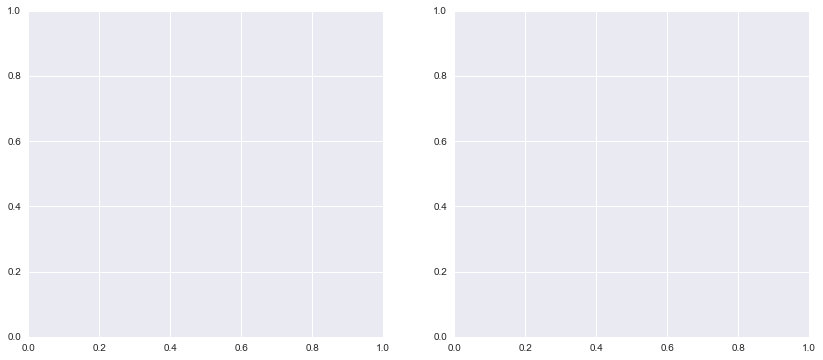

In [55]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14, 6))
plot_roc(cv_strategy.get_n_splits(), job.metrics, ax0, "complete dataset")
plot_roc(cv_strategy.get_n_splits(), job_reduced.metrics, ax1, "reduced dataset")

In [134]:
sys.executable

'/Users/pierreguilmin/anaconda3/bin/python'

## Random Forest

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [301.90s | 7.01s]
  → accuracy: [0.89 | 1.00]
  → ROC AUC : [0.89 | 1.00]
  → Best parameters : {'max_depth': 50, 'n_estimators': 1000}
    0.85 ± 0.01 for {'max_depth': 5, 'n_estimators': 10}
    0.86 ± 0.01 for {'max_depth': 5, 'n_estimators': 100}
    0.86 ± 0.00 for {'max_depth': 5, 'n_estimators': 1000}
    0.88 ± 0.00 for {'max_depth': 20, 'n_estimators': 10}
    0.89 ± 0.00 for {'max_depth': 20, 'n_estimators': 100}
    0.90 ± 0.00 for {'max_depth': 20, 'n_estimators': 1000}
    0.88 ± 0.01 for {'max_depth': 50, 'n_estimators': 10}
    0.89 ± 0.00 for {'max_depth': 50, 'n_estimators': 100}
    0.90 ± 0.00 for {'max_depth': 50, 'n_estimators': 1000}
Fold 1: [311.69s | 4.70s]
  → accuracy: [0.88 | 0.93]
  → ROC AUC : [0.90 | 0.96]
  → Best parameters : {'max_depth': 20, 'n_estimators': 1000}
    0.86 ± 0.01 for {'max_depth': 5, 'n_estimators': 10}

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,301.899,7.00568,1,0.8875,1,0.894499,"{'max_depth': 50, 'n_estimators': 1000}"
1,311.694,4.70313,0.928949,0.880331,0.964923,0.903131,"{'max_depth': 20, 'n_estimators': 1000}"
2,313.319,7.27124,0.928122,0.879963,0.965306,0.891553,"{'max_depth': 20, 'n_estimators': 1000}"
3,409.016,11.0728,1,0.884559,1,0.892541,"{'max_depth': 50, 'n_estimators': 1000}"
4,361.309,7.69033,1,0.887132,1,0.896806,"{'max_depth': 50, 'n_estimators': 1000}"


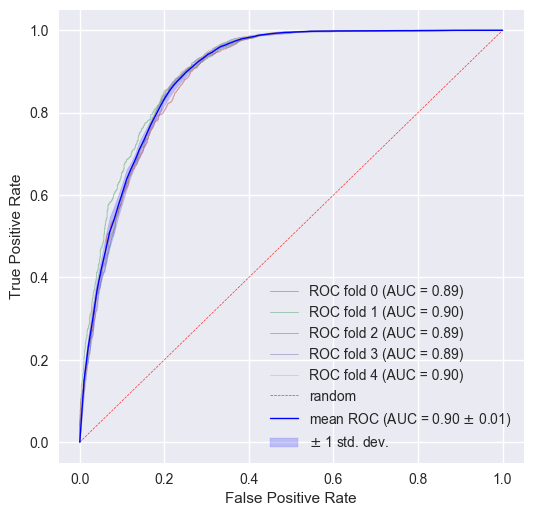

In [25]:
from sklearn.ensemble import RandomForestClassifier

parameters_grid = [
    {'n_estimators': [10, 100, 1000], 'max_depth': [5, 20, 50]}
]

model_GS_RandomForestClassifier = GridSearchCV(RandomForestClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_RandomForestClassifier, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)


## Mean accuracy: 0.82 ± 0.01
## Mean ROC AUC : 0.77 ± 0.01


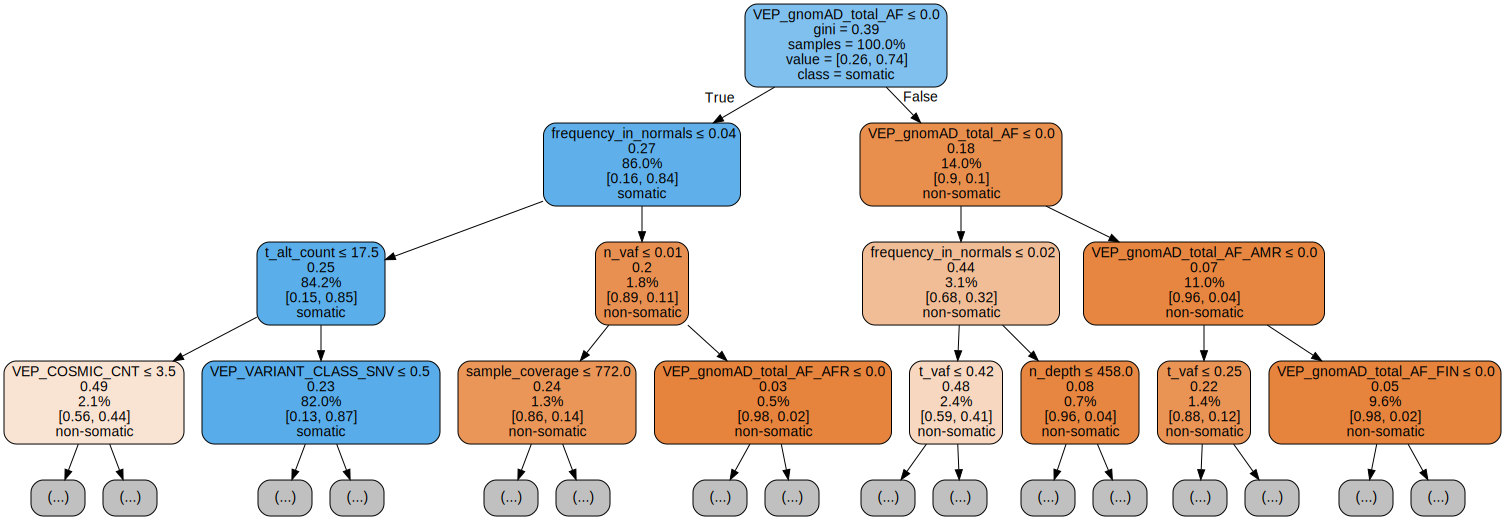

In [26]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 1)
run_model(model_DecisionTreeClassifier, X, y, cv_strategy)

model_DecisionTreeClassifier.fit(X, y)
dot_data = export_graphviz(model_DecisionTreeClassifier, out_file = None, max_depth = 3, feature_names = X.columns.tolist(), class_names = ['non-somatic', 'somatic'], label = 'root', filled = True, proportion = True, rounded = True, special_characters = True, precision = 2) 
graph = graphviz.Source(dot_data) 
graph

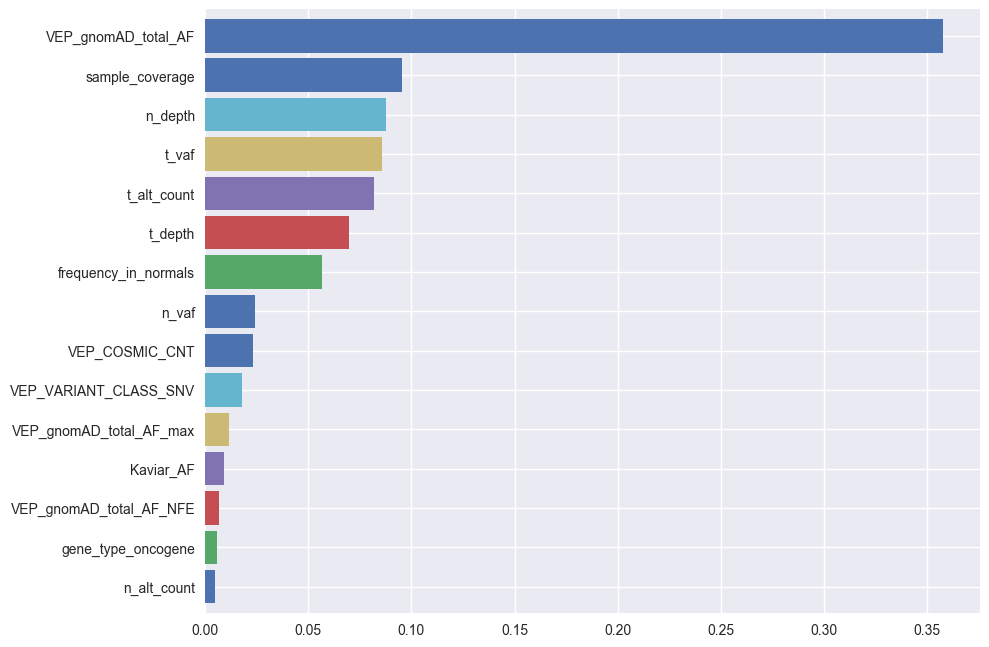

In [27]:
feature_importance = pd.Series(model_DecisionTreeClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(15)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);


## Mean accuracy: 0.88 ± 0.00
## Mean ROC AUC : 0.89 ± 0.01


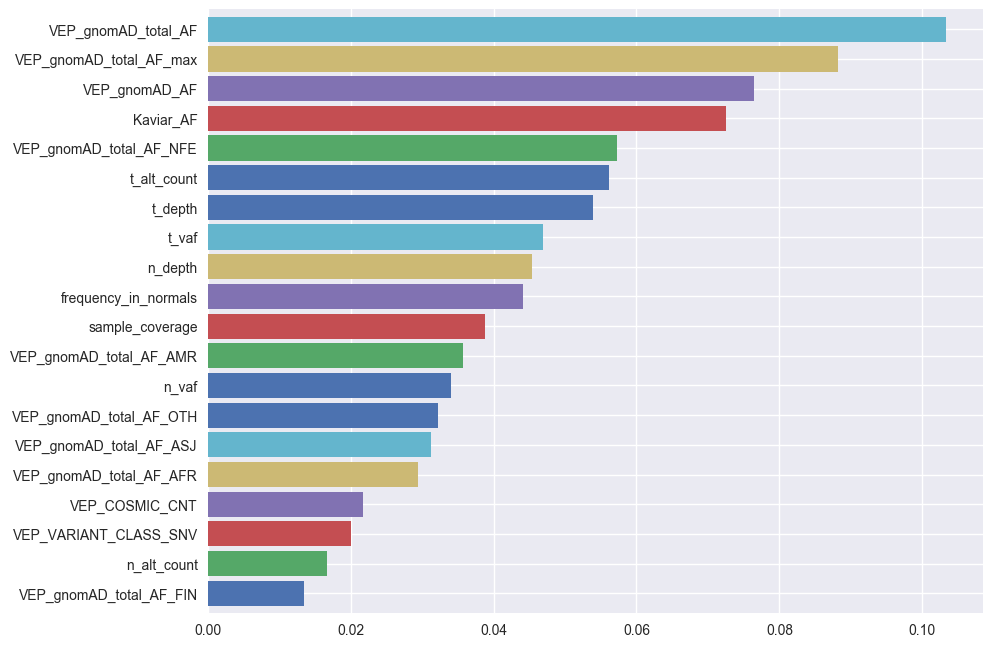

In [28]:
from sklearn.ensemble import RandomForestClassifier

model_best_RandomForestClassifier = RandomForestClassifier(random_state = 1, n_estimators = 100, max_depth = 20)
run_model(model_best_RandomForestClassifier, X, y, cv_strategy)

model_best_RandomForestClassifier.fit(X, y)

feature_importance = pd.Series(model_best_RandomForestClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(20)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);

## Gradient Boosting

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [34.91s | 0.08s]
  → accuracy: [0.88 | 0.88]
  → ROC AUC : [0.88 | 0.90]
  → Best parameters : {'learning_rate': 0.1, 'n_estimators': 100}
    0.82 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 10}
    0.85 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 100}
    0.84 ± 0.00 for {'learning_rate': 0.1, 'n_estimators': 10}
    0.88 ± 0.00 for {'learning_rate': 0.1, 'n_estimators': 100}
    0.87 ± 0.01 for {'learning_rate': 1, 'n_estimators': 10}
    0.87 ± 0.01 for {'learning_rate': 1, 'n_estimators': 100}
Fold 1: [34.75s | 0.08s]
  → accuracy: [0.88 | 0.88]
  → ROC AUC : [0.90 | 0.89]
  → Best parameters : {'learning_rate': 0.1, 'n_estimators': 100}
    0.83 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 10}
    0.85 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 100}
    0.85 ± 0.01 for {'learning_rate': 0.1, 'n_estimators': 10}
    0.8

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,34.9126,0.0791869,0.882118,0.880331,0.896267,0.882781,"{'learning_rate': 0.1, 'n_estimators': 100}"
1,34.751,0.0789692,0.882991,0.880147,0.89475,0.895432,"{'learning_rate': 0.1, 'n_estimators': 100}"
2,34.4062,0.0763741,0.883083,0.879596,0.896355,0.880396,"{'learning_rate': 0.1, 'n_estimators': 100}"
3,35.1259,0.0756898,0.884002,0.879596,0.896101,0.886436,"{'learning_rate': 0.1, 'n_estimators': 100}"
4,33.4458,0.0784383,0.882348,0.881801,0.89522,0.889147,"{'learning_rate': 0.1, 'n_estimators': 100}"


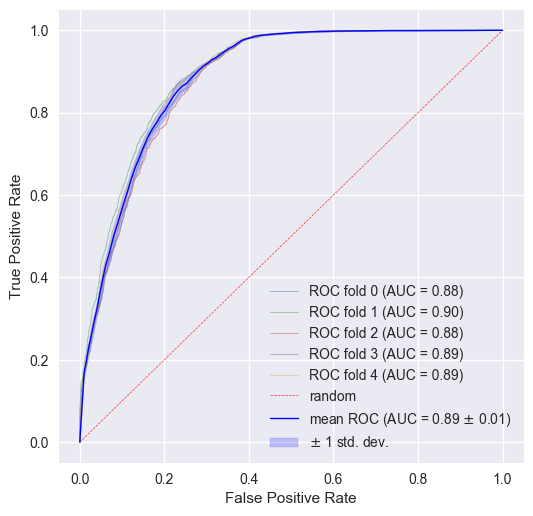

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

parameters_grid = [
    {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [10, 100]}
]

model_GS_GradientBoostingClassifier = GridSearchCV(GradientBoostingClassifier(random_state = 1), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_GradientBoostingClassifier, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)


## Mean accuracy: 0.88 ± 0.00
## Mean ROC AUC : 0.89 ± 0.01


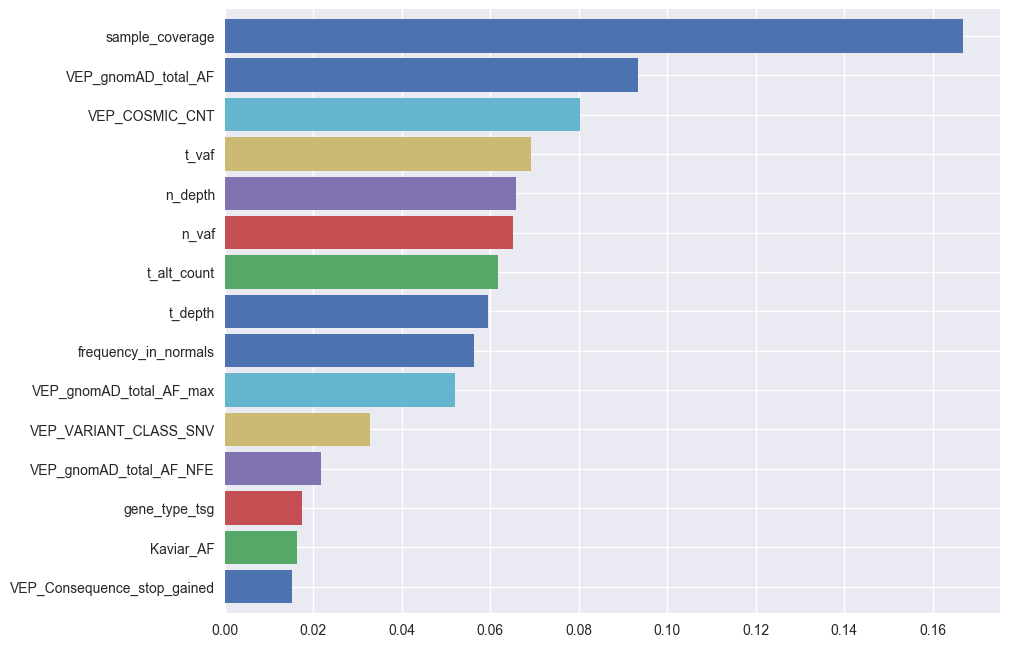

In [30]:
model_best_GradientBoostingClassifier = GradientBoostingClassifier(random_state = 1, learning_rate = 0.1, n_estimators = 100)
run_model(model_best_GradientBoostingClassifier, X, y, cv_strategy)

model_best_GradientBoostingClassifier.fit(X, y)

feature_importance = pd.Series(model_best_GradientBoostingClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(15)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

parameters_grid = [
    {'C': [0.1, 1, 10]}
]
#model_GS_SVC = GridSearchCV(SVC(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)
model_GS_SVC = SVC(kernel='linear', probability=True)


fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_SVC, X, y, cv_strategy, grid_search = False, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]



## Other

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = np.linspace(0.1, 1.0, 5), cv = 5)

for i in range(n_folds):
    plt.plot(train_sizes, train_scores[i], linewidth = 0.5, alpha = 0.4, color = 'r',
                     label = 'training score fold %d' % i)
    plt.plot(train_sizes, test_scores[i], linewidth = 0.5, alpha = 0.4, color = 'g',
                     label = 'test score fold %d' % i)
    
train_scores_mean = np.mean(train_scores, axis = 0)
train_scores_std = np.std(train_scores, axis = 0)
test_scores_mean = np.mean(test_scores, axis = 0)
test_scores_std = np.std(test_scores, axis = 0)

plt.plot(train_sizes, train_scores_mean, 'o-r', linewidth = 1,
        label = 'mean training score')
plt.plot(train_sizes, test_scores_mean, 'o-g', linewidth = 1,
         label = 'mean test score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')


plt.xlabel("Training size")
plt.ylabel("Accuracy score")
plt.legend(loc = "lower right", prop = {'size': 5})

Gradient boosting